<a href="https://colab.research.google.com/github/takrim1999/bdset/blob/DL/CNN2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Streaming output truncated to the last 5000 lines.
/kaggle/input/dogs-vs-cats/train/cats/cat.12067.jpg
/kaggle/input/dogs-vs-cats/train/cats/cat.6754.jpg
/kaggle/input/dogs-vs-cats/train/cats/cat.12113.jpg
/kaggle/input/dogs-vs-cats/train/cats/cat.2602.jpg
/kaggle/input/dogs-vs-cats/train/cats/cat.9283.jpg
/kaggle/input/dogs-vs-cats/train/cats/cat.5087.jpg
/kaggle/input/dogs-vs-cats/train/cats/cat.10515.jpg
/kaggle/input/dogs-vs-cats/train/cats/cat.10254.jpg
/kaggle/input/dogs-vs-cats/train/cats/cat.6611.jpg
/kaggle/input/dogs-vs-cats/train/cats/cat.8950.jpg
/kaggle/input/dogs-vs-cats/train/cats/cat.12290.jpg
/kaggle/input/dogs-vs-cats/train/cats/cat.4134.jpg
/kaggle/input/dogs-vs-cats/train/cats/cat.8313.jpg
/kaggle/input/dogs-vs-cats/train/cats/cat.6452.jpg
/kaggle/input/dogs-vs-cats/train/cats/cat.244.jpg
/kaggle/input/dogs-vs-cats/train/cats/cat.4719.jpg
/kaggle/input/dogs-vs-cats/train/cats/cat.7106.jpg
/kaggle/input/dogs-vs-cats/train/cats/cat.9879.jpg
/kaggle/input/dogs-vs-cats/

In [3]:
# --- লাইব্রেরি ইম্পোর্ট ---
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from keras import Sequential, Input
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.layers import RandomFlip, RandomRotation, RandomZoom
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix

In [4]:
# --- 1️⃣ Reproducibility Seeds ---
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

In [5]:
# --- 2️⃣ Constants ---
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 16
IMAGE_SIZE = (128, 128)
EPOCHS = 10
THRESHOLD = 0.5

In [7]:
# --- 3️⃣ Dataset Paths ---
TRAIN_DIR = '/kaggle/input/dogs-vs-cats/train'
TEST_DIR  = '/kaggle/input/dogs-vs-cats/test'  # test images inside subfolders 'dogs' and 'cats'

In [8]:
# --- 4️⃣ Data Generator ---
train_ds = keras.utils.image_dataset_from_directory(
    directory=TRAIN_DIR,
    labels="inferred",
    label_mode="int",
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    shuffle=True,
    seed=SEED,
    validation_split=0.3,
    subset='training'
)

val_ds = keras.utils.image_dataset_from_directory(
    directory=TRAIN_DIR,
    labels="inferred",
    label_mode="int",
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    shuffle=True,
    seed=SEED,
    validation_split=0.3,
    subset='validation'
)

Found 20000 files belonging to 2 classes.
Using 14000 files for training.
Found 20000 files belonging to 2 classes.
Using 6000 files for validation.


In [9]:
# --- 5️⃣ Data Preprocessing & Augmentation ---
def prepare(ds, training=False):
    ds = ds.map(lambda x, y: (tf.cast(x, tf.float32)/255.0, y),
                num_parallel_calls=AUTOTUNE)
    if training:
        data_augmentation = Sequential([
            RandomFlip('horizontal', seed=SEED),
            RandomRotation(0.2, seed=SEED),
            RandomZoom(0.2, seed=SEED)
        ])
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                    num_parallel_calls=AUTOTUNE)
    return ds.prefetch(buffer_size=AUTOTUNE)

train_ds = prepare(train_ds, training=True)
val_ds   = prepare(val_ds, training=False)
print("Data Processing Complete!")

Data Processing Complete!


In [10]:
# --- 6️⃣ CNN Model Architecture ---
model = Sequential([
    Input(shape=(*IMAGE_SIZE, 3)),

    Conv2D(32, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.2, seed=SEED),
    Dense(64, activation='relu'),
    Dropout(0.2, seed=SEED),
    Dense(1, activation='sigmoid')
])

In [11]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,296,897 (16.39 MB)

 Trainable params: 4,296,449 (16.39 MB)

 Non-trainable params: 448 (1.75 KB)

In [26]:
# --- 7️⃣ Model Compilation ---
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
    keras.callbacks.ModelCheckpoint('model.keras', save_best_only=True)
]

In [27]:
# --- 8️⃣ Model Training ---
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=callbacks
)

Epoch 1/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 65s 68ms/step - accuracy: 0.7889 - loss: 0.4595 - val_accuracy: 0.7658 - val_loss: 0.6186
Epoch 2/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 82s 94ms/step - accuracy: 0.8068 - loss: 0.4335 - val_accuracy: 0.7777 - val_loss: 0.4694
Epoch 3/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 65s 74ms/step - accuracy: 0.8144 - loss: 0.4260 - val_accuracy: 0.7938 - val_loss: 0.5532
Epoch 4/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 60s 69ms/step - accuracy: 0.8218 - loss: 0.4044 - val_accuracy: 0.7673 - val_loss: 0.4790
Epoch 5/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 62s 71ms/step - accuracy: 0.8189 - loss: 0.4033 - val_accuracy: 0.8193 - val_loss: 0.4101
Epoch 6/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 81s 70ms/step - accuracy: 0.8266 - loss: 0.3981 - val_accuracy: 0.8330 - val_loss: 0.3793
Epoch 7/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 62s 70ms/step - accuracy: 0.8294 - loss: 0.3848 - val_accuracy: 0.8320 - val_loss: 0.3986
Epoch 8/10
875/875 ━━━━━━━━━━━━━━━━━━━━ 59s 67ms/step - accuracy: 0.8326 - loss: 0.3788 - 

In [29]:
# --- 9️⃣ Load Best Model ---
best_model = load_model('model.keras')

In [30]:
# --- 🔟 Prediction Function ---
def predict(image_path, model, image_size=IMAGE_SIZE, threshold=THRESHOLD):
    img = Image.open(image_path).convert("RGB")
    img_resized = img.resize(image_size)
    inp = np.array(img_resized)/255.0
    inp = np.expand_dims(inp, axis=0).astype(np.float32)

    prob = model.predict(inp)[0][0]
    label = "Dog" if prob >= threshold else "Cat"

    print(f"Probability (Dog): {prob:.4f} → Prediction: {label}")

    plt.imshow(img)
    plt.axis("off")
    plt.title(f"{label} ({prob:.2f})")
    plt.show()

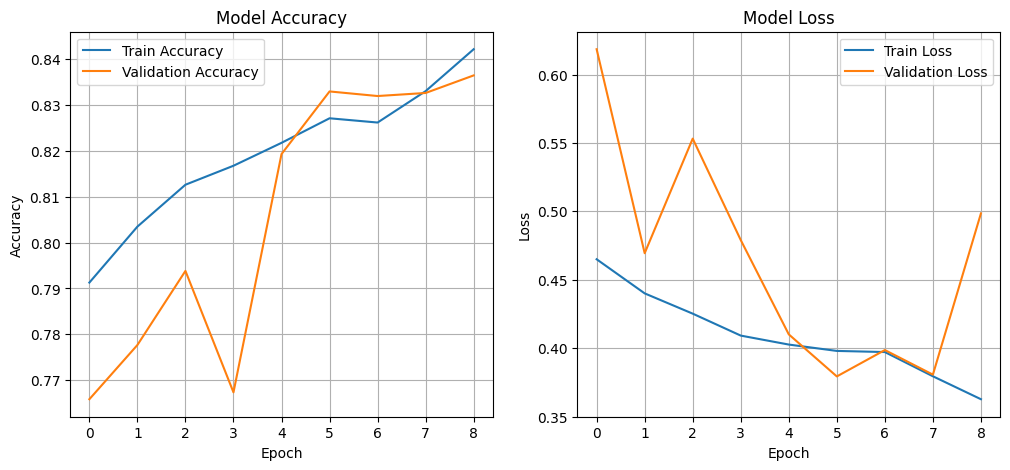

In [31]:
# --- 11️⃣ Training History Visualization ---
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

In [32]:
# --- 12️⃣ Test Set Evaluation ---
test_ds = keras.utils.image_dataset_from_directory(
    directory=TEST_DIR,
    labels="inferred",
    label_mode="int",
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    shuffle=False
)
test_ds = prepare(test_ds, training=False)

y_true = []
y_pred = []

for images, labels in test_ds:
    probs = best_model.predict(images)
    preds = (probs >= THRESHOLD).astype(int).flatten()

    y_pred.extend(preds)
    y_true.extend(labels.numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

Found 5000 files belonging to 2 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━

In [33]:
# --- Classification Report ---
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=['Cat','Dog']))

Classification Report:
              precision    recall  f1-score   support

         Cat       0.85      0.83      0.84      2500
         Dog       0.84      0.86      0.85      2500

    accuracy                           0.85      5000
   macro avg       0.85      0.85      0.85      5000
weighted avg       0.85      0.85      0.85      5000



Confusion Matrix:
 [[2083  417]
 [ 354 2146]]


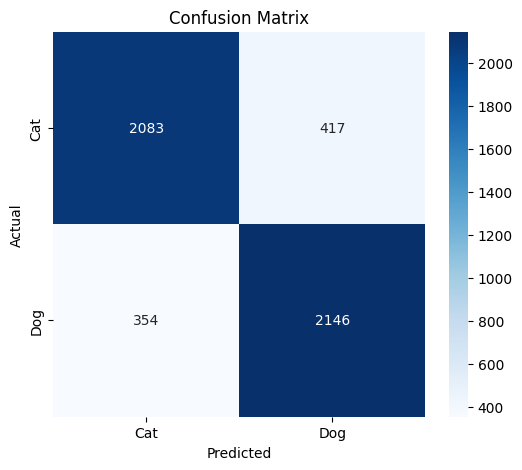

In [34]:
# --- Confusion Matrix ---
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)


plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Cat','Dog'], yticklabels=['Cat','Dog'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [35]:
def predict(image_path, model, image_size=IMAGE_SIZE, threshold=0.5):
    img = Image.open(image_path).convert("RGB")
    img_resized = img.resize(image_size)
    inp = np.array(img_resized) / 255.0
    inp = np.expand_dims(inp, axis=0).astype(np.float32)

    prob = model.predict(inp)[0][0]
    label = "Dog" if prob >= threshold else "Cat"

    print(f"Probability (Dog): {prob:.4f} → Prediction: {label}")
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"{label} ({prob:.2f})")
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 919ms/step
Probability (Dog): 0.8599 → Prediction: Dog


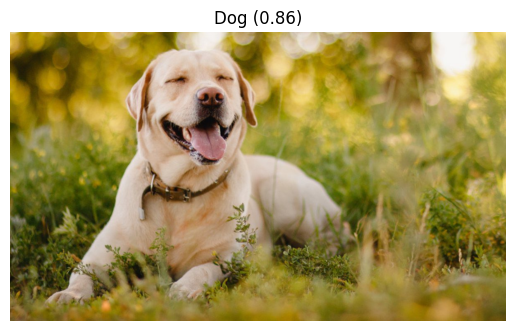

In [36]:
predict("/content/dog1.jpg", best_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Probability (Dog): 0.9331 → Prediction: Dog


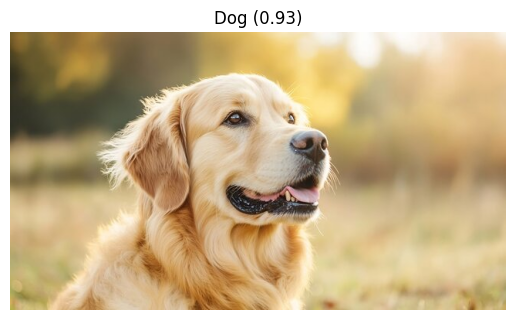

In [37]:
predict("/content/dog2.jpg", best_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Probability (Dog): 0.6867 → Prediction: Dog


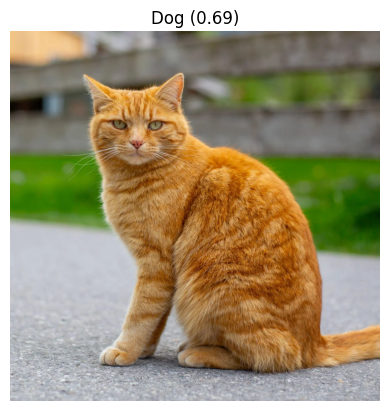

In [38]:
predict("/content/cat.jpg", best_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
Probability (Dog): 0.0532 → Prediction: Cat


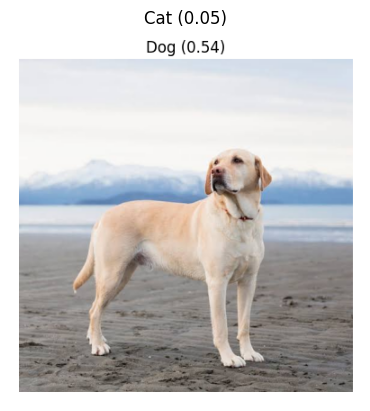

In [39]:
predict("/content/dog3.png", best_model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
Probability (Dog): 0.5592 → Prediction: Dog


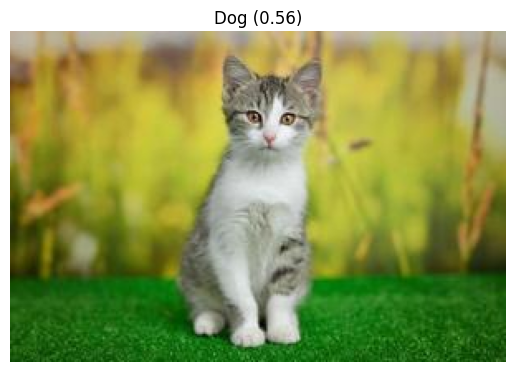

In [40]:
predict("/content/cat2.jpg", best_model)